In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
np.complex = complex

In [2]:
import torch
from torch import nn
import librosa
import soundfile as sf
import os

In [3]:
sns.set(rc={"figure.figsize":(9,6)})

In [4]:
data = pd.read_csv("train.csv")

In [5]:
data.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


### Sound preprocessing test

In [6]:
audio_path = 'morse_dataset/morse_dataset/1.opus'
y, sr = librosa.load(audio_path, sr=8000)

In [7]:
y_trimmed, _ = librosa.effects.trim(y, top_db=30)

In [8]:
y_normalized = y_trimmed / np.max(np.abs(y_trimmed))

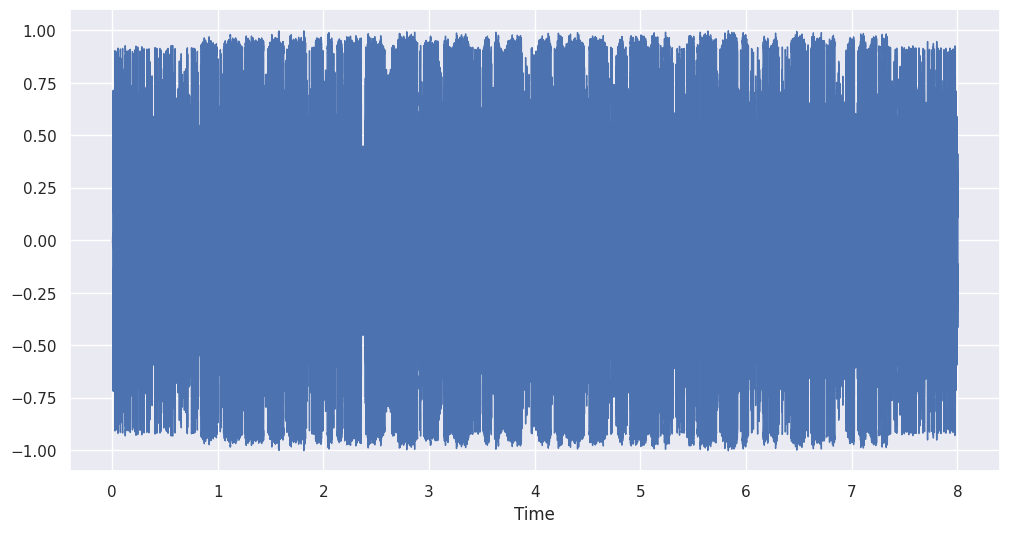

In [9]:
import librosa.display

plt.figure().set_figwidth(12)
librosa.display.waveshow(y_normalized, sr=sr)

### Preprocessing

In [10]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=8000)
    y, _ = librosa.effects.trim(y, top_db=30)
    y = y / np.max(np.abs(y))

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=64)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max,top_db=40)
    return mel_spec_db
    
def show_melspect(mel_spec):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=8000, hop_length=128, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Мел-спектрограмма')
    plt.tight_layout()
    plt.show()

In [11]:
mel = extract_features(audio_path)

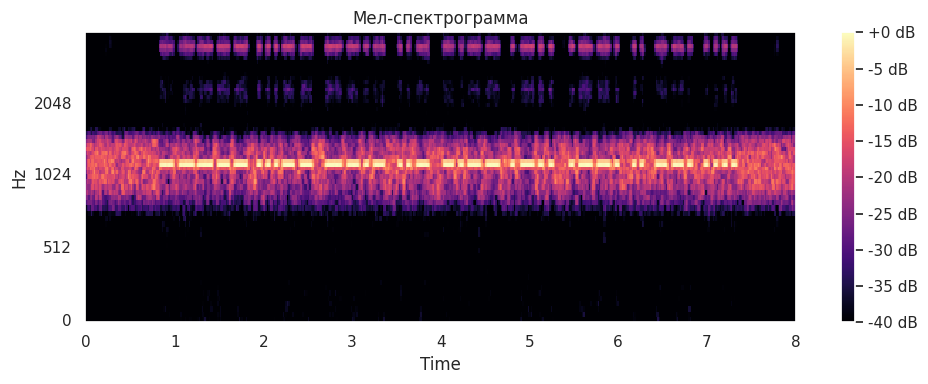

In [12]:
show_melspect(mel)

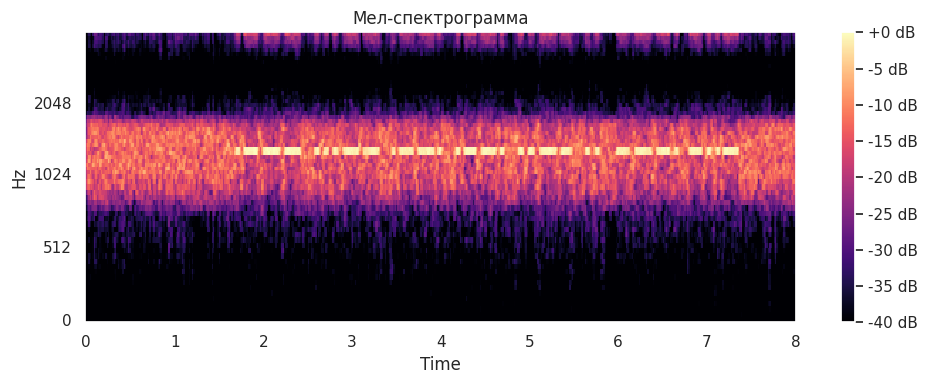

(64, 501)

In [13]:
mel5 = extract_features("morse_dataset/morse_dataset/27762.opus")
show_melspect(mel5)
mel5.shape

### Char dict

In [14]:
all_text = "".join(data["message"].astype(str).tolist())
unique_chars = sorted(set(all_text))
blank_token = "_"
vocab = [blank_token] + unique_chars
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}

In [15]:
# Extract Tensor
def extract_mel_spectrogram(path, sr=8000, n_mels=64, n_fft=512, hop_length=128):
    y, _ = librosa.load(path, sr=sr)

    y, _ = librosa.effects.trim(y, top_db=30)
    y = y / (np.max(np.abs(y)) + 1e-6)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max, top_db=40)
    return torch.from_numpy(mel_db).unsqueeze(0).float()

import time

# Замер времени для одного аудиофайла
start = time.time()
spec = extract_mel_spectrogram("morse_dataset/morse_dataset/4567.opus")
print(f"Mel-spectrogram time: {time.time() - start:.3f}s")

Mel-spectrogram time: 0.059s


In [21]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class MorseDataset(Dataset):
    def __init__(self, csv_path, audio_dir):
        self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row["id"]
        text = row["message"]
        spec = extract_mel_spectrogram(os.path.join(self.audio_dir, fname))
        target = torch.tensor([char2idx[c] for c in text], dtype=torch.long)
        return spec, target

In [22]:
def collate_fn(batch):
    specs, targets = zip(*batch)
    # длины по времени
    spec_lens = torch.tensor([s.shape[-1] for s in specs], dtype=torch.long)
    # паддим спектрограммы до max T
    # сначала меняем shape [1, n_mels, T] → [T, n_mels] для pad_sequence
    specs_seq = [s.squeeze(0).transpose(0,1) for s in specs]
    specs_padded = pad_sequence(specs_seq, batch_first=True)  
    # обратно в [B, 1, n_mels, T_max]
    specs_padded = specs_padded.transpose(1,2).unsqueeze(1)

    # таргеты
    target_lens = torch.tensor([t.numel() for t in targets], dtype=torch.long)
    targets_concat = torch.cat(targets)
    return specs_padded, spec_lens, targets_concat, target_lens

In [26]:
class MorseCTCModel(nn.Module):
    def __init__(self, n_mels=64, num_classes=len(vocab), lstm_hidden=128, lstm_layers=2):
        super().__init__()
        # CNN‑encoder
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),  # → [B, 16, n_mels/2, T/2]
            nn.ReLU(inplace=True),
        
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # → [B, 32, n_mels/4, T/4]
            nn.ReLU(inplace=True),
        
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # без понижения размера
            nn.ReLU(inplace=True)
        )
        # размер признаков для LSTM
        self.lstm_input_size = (n_mels // 4) * 32

        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3 if lstm_layers > 1 else 0
        )
        self.classifier = nn.Linear(lstm_hidden * 2, num_classes)

    def forward(self, x):
        """
        x: [B, 1, n_mels, T]
        """
        B = x.size(0)
        start = time.time()
        x = self.cnn(x)  # [B, C, n_mels/4, T/4]
        print(f"cnn time: {time.time() - start:.3f}s")
        # подготовка для LSTM
        x = x.permute(0, 3, 1, 2)             # [B, T', C, F]
        Tprime = x.size(1)
        start = time.time()
        x = x.contiguous().view(B, Tprime, -1)  # [B, T', C*F]
        print(f"permute time: {time.time() - start:.3f}s")

        start = time.time()
        x, _ = self.lstm(x)                   # [B, T', 2*hidden]
        print(f"ltsm time: {time.time() - start:.3f}s")
        start = time.time()
        x = self.classifier(x)                # [B, T', num_classes]
        print(f"class time: {time.time() - start:.3f}s")
        # CTC будет работать с log-probs
        return x.log_softmax(dim=-1)

In [26]:
class MorseCTCModel(nn.Module):
    def __init__(self, n_mels=64, num_classes=len(vocab), lstm_hidden=512, lstm_layers=2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 32, 3, padding=1),  # Keep channels same
            nn.GELU(),
            nn.MaxPool2d(2),
            
            nn.Dropout2d(0.1)
        )
        self.lstm_input_size = (n_mels//4) * 32
        
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            dropout=0.3 if lstm_layers > 1 else 0,
            bidirectional=True,
            batch_first=True
        )
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden*2, lstm_hidden),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(lstm_hidden, num_classes)
        )

    def forward(self, x):
        print('f')
        x = self.cnn(x)
        x = x.permute(0, 3, 1, 2).flatten(2)
        x, _ = self.lstm(x)
        return self.classifier(x).log_softmax(-1)

In [27]:
ds = MorseDataset("train.csv", "morse_dataset/morse_dataset/")
loader = DataLoader(ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
model = MorseCTCModel()
criterion = nn.CTCLoss(blank=char2idx[blank_token], zero_infinity=True)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001, 
    weight_decay=1e-4  # опционально: L2-регуляризация
)
# тестовый прогон
start = time.time()
specs, spec_lens, targets, target_lens = next(iter(loader))
out = model(specs)           # [B, T', C]
out = out.permute(1,0,2)     # → [T', B, C]
loss = criterion(out, targets, spec_lens // 4, target_lens)
print(f"all: {time.time() - start:.3f}s")
print("CTC loss:", loss.item())

cnn time: 0.101s
permute time: 0.001s
ltsm time: 0.059s
class time: 0.001s
all: 1.514s
CTC loss: 50.7833251953125


cnn time: 0.105s
permute time: 0.001s
ltsm time: 0.060s
class time: 0.001s
permute: 0.167s
criterion: 0.001s
optimizer zero grad: 0.000s
backward: 0.131s
optimizer step: 0.004s
total: 0.303s


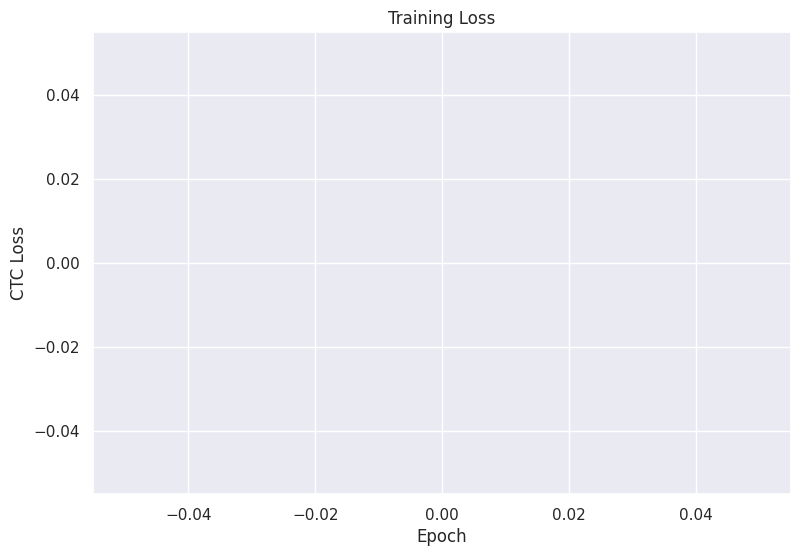

In [33]:
num_epochs = 10
train_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for specs, slens, targets, tlens in loader:
        start = time.time()
        total = start
        logits = model(specs).permute(1, 0, 2)
        print(f"permute: {time.time() - start:.3f}s")

        start = time.time()
        loss = criterion(logits, targets, slens // 4, tlens)
        print(f"criterion: {time.time() - start:.3f}s")
        
        start = time.time()
        optimizer.zero_grad()
        print(f"optimizer zero grad: {time.time() - start:.3f}s")
        start = time.time()
        loss.backward()
        print(f"backward: {time.time() - start:.3f}s")
        start = time.time()
        optimizer.step()
        print(f"optimizer step: {time.time() - start:.3f}s")
        epoch_loss += loss.item()
        print(f"total: {time.time() - total:.3f}s")
        break
    break
    train_losses.append(epoch_loss / len(loader))
    print(f"Epoch {epoch+1} — Loss: {epoch_loss:.4f}")

plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.title("Training Loss")
plt.show()